In [2]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

from models.macaw import MACAW

import sys
sys.path.append('..')

from utils.datasets import TorchDataset as TD
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mode = 'test'
test_block = 'flat'
nlatents = 64
ncauses =19
sex_idx = 9
PD_idx = 18

In [4]:
model = MACAW(nlatents=nlatents).to('cuda')
checkpoint = torch.load(f'checkpoints/act-macaw-{test_block}/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
ds = TD(f'/data/Data/PD/activations_{test_block}_{mode}')
data_loader = DataLoader(ds, batch_size=128, shuffle=False)

In [6]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1 - y_true) * np.log(1 - y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0 + term_1, axis=0)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)


In [7]:
import numpy as np

g_dict = {'Study': np.arange(9), 'Sex': [0,1]}
cf_dict = {}


temp = {k:0 for k in range(9)}
model.eval()

grp_mean = np.zeros((len(ds), nlatents+ncauses))
for v in range(9):
    obs = []
    cfs = []
    cf_vals = temp.copy()
    cf_vals[v] = 1   
    for b in data_loader:             
        x_obs, x_cf = model.counterfactuals(b.to('cuda'), cf_vals=cf_vals)
        obs.append(x_obs)
        cfs.append(x_cf)

    obs = np.vstack(obs)
    cf = np.vstack(cfs)
    grp_mean += cf

    cf_dict[f'Study_{v}'] = cf

cf_dict[f'Study_mean'] = grp_mean / 9

grp_mean = np.zeros((len(ds), nlatents+ncauses))
for v in [0,1]:
    obs = []
    cfs = []
    for b in data_loader:             
        x_obs, x_cf = model.counterfactuals(b.to('cuda'), cf_vals={sex_idx:v})
        obs.append(x_obs)
        cfs.append(x_cf)

    obs = np.vstack(obs)
    cf = np.vstack(cfs)
    grp_mean += cf

    cf_dict[f'Sex_{v}'] = cf

cf_dict[f'Sex_mean'] = grp_mean / 2


In [8]:
from sklearn.metrics import roc_curve, auc

obs_pred = sigmoid(obs[:, ncauses:] @ weights.T + bias).squeeze()
fpr, tpr, thresholds = roc_curve(obs[:,PD_idx], obs_pred)
obs_roc_auc = auc(fpr, tpr)
obs_bce = BinaryCrossEntropy(obs[:, PD_idx], obs_pred)
print(f'Obs- AUROC: {obs_roc_auc}, BCE:{obs_bce}')

df = pd.DataFrame(
    {'pd_true': obs[:, PD_idx], 'obs_pred': obs_pred, 'sex': obs[:, sex_idx], 'study': np.argmax(obs[:, :9], axis=1), 'scanner': np.argmax(obs[:, 10:18], axis=1)})
df

NameError: name 'weights' is not defined

In [101]:
for k, v in g_dict.items():
    mean_pred = sigmoid(cf_dict[f'{k}_mean'][:, ncauses:] @ weights.T + bias).squeeze()
    fpr, tpr, thresholds = roc_curve(obs[:, PD_idx], mean_pred)
    obs_roc_auc = auc(fpr, tpr)
    obs_bce = BinaryCrossEntropy(obs[:, PD_idx], mean_pred)
    print(f'{k}- AUROC: {obs_roc_auc}, BCE:{obs_bce}')
    df[f'{k}_pred'] = mean_pred

Study- AUROC: 0.7767989271180169, BCE:0.6041449539099527
Sex- AUROC: 0.8149509803921569, BCE:0.5594280824824865


In [102]:
def compute_scanner_roc(df, y_true_col='pd_true', y_prob_col='pd_pred',
                        subgroup_col='scanner'):
    unique_scanners = df[subgroup_col].unique()

    scanner_roc_metrics = {}
    accuracy = {}
    for scanner in unique_scanners:
        scanner_df = df[df[subgroup_col] == scanner]
        y_true = scanner_df[y_true_col]
        y_prob = scanner_df[y_prob_col]

        try:
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)

            # Store metrics
            scanner_roc_metrics[scanner] = {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds,
                'auc': roc_auc,
                'total_samples': len(scanner_df)
            }

        except ValueError as e:
            print(f"Error computing ROC for {subgroup_col} {scanner}: {e}")

    return scanner_roc_metrics


def plot_scanner_roc_curves(df, y_true_col='y_true', y_prob_col='y_pred',
                            subgroup_col='scanner', figsize=(6, 6)):
    # Compute ROC metrics for each scanner
    scanner_roc_metrics = compute_scanner_roc(
        df, y_true_col, y_prob_col, subgroup_col
    )

    fig, axs = plt.subplots(1, 1, figsize=figsize)
    colors = sns.color_palette('husl', len(scanner_roc_metrics))

    # Plot ROC for each scanner
    for (scanner, metrics), color in zip(scanner_roc_metrics.items(), colors):
        axs.plot(metrics['fpr'], metrics['tpr'],
                    label=f'{scanner} (AUC = {metrics["auc"]:.3f}, n={metrics["total_samples"]})',
                    color=color)

    # Plot random classifier line
    axs.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # Customize plot
    axs.set_xlim([0.0, 1.0])
    axs.set_ylim([0.0, 1.05])
    axs.set_xlabel('False Positive Rate', fontsize=12)
    axs.set_ylabel('True Positive Rate', fontsize=12)
    axs.set_title(f'ROC Curves by {subgroup_col}', fontsize=14)
    axs.legend(loc="lower right", fontsize=10)
    axs.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/{y_prob_col}_{subgroup_col}.pdf', dpi=300)
    plt.show()

    return scanner_roc_metrics


# Comprehensive analysis function
def comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='pd_pred',
                                      subgroup_col='scanner', thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)

    # Compute ROC curves
    roc_metrics= plot_scanner_roc_curves(df, y_true_col, y_prob_col, subgroup_col)

    return roc_metrics

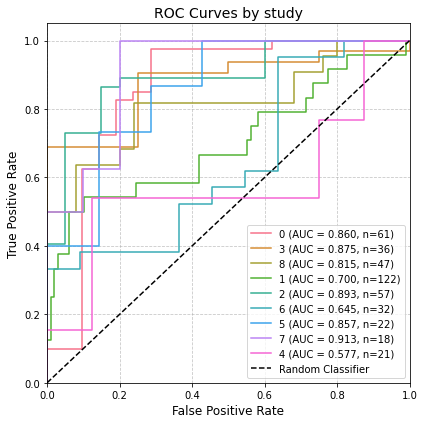

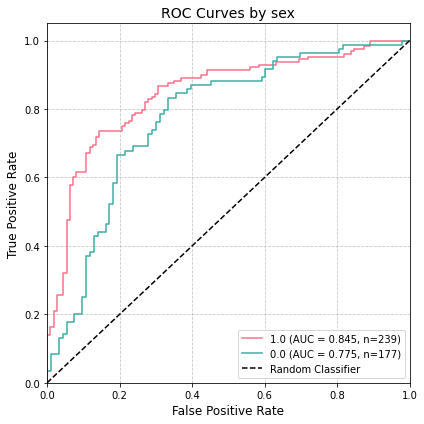

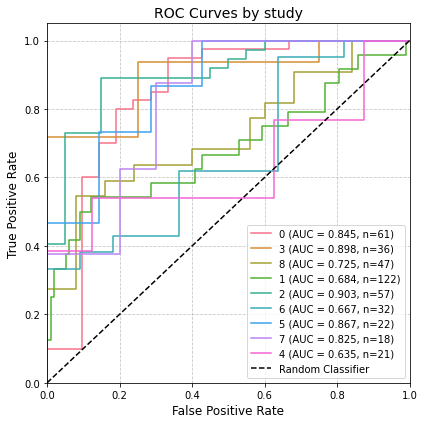

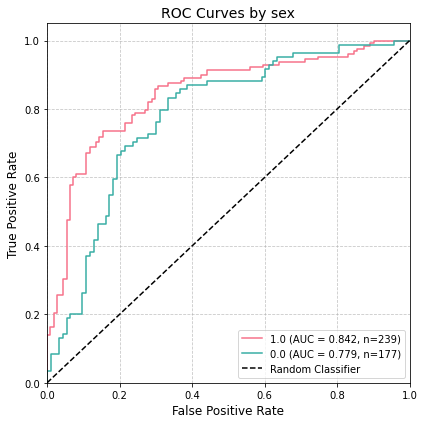

In [103]:
study_obs_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='obs_pred',
                                                        subgroup_col='study')

sex_obs_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='obs_pred',
                                                        subgroup_col='sex')

study_cf_study_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='Study_pred',
                                                        subgroup_col='study')

sex_cf_sex_metrics = comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='Sex_pred',
                                                        subgroup_col='sex')

In [104]:
cf_study_study_auc = {}

for a in study_obs_metrics.keys():
    cf_study_study_auc[a] = (study_cf_study_metrics[a]['auc'] - study_obs_metrics[a]['auc'])
    
cf_sex_sex_auc = {}

for a in sex_obs_metrics.keys():
    cf_sex_sex_auc[a] = (sex_cf_sex_metrics[a]['auc'] - sex_obs_metrics[a]['auc'])   

In [105]:
cf_study_study_auc

{0: -0.014285714285714235,
 3: 0.0234375,
 8: -0.089090909090909,
 1: -0.01573129251700678,
 2: 0.009459459459459474,
 6: 0.021645021645021578,
 5: 0.009523809523809601,
 7: -0.08750000000000013,
 4: 0.05769230769230782}

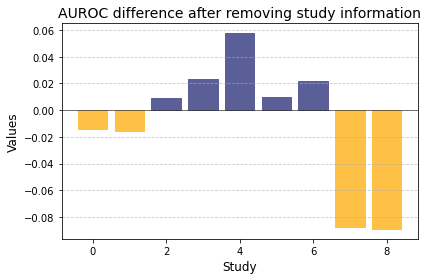

In [106]:
plt.figure(figsize=(6, 4))

# Create bar plot with custom colors
bars = plt.bar(cf_study_study_auc.keys(), cf_study_study_auc.values())

# Color bars based on positive/negative values
for i, value in enumerate(cf_study_study_auc.values()):
    if value >= 0:
        bars[i].set_color('#5B5F97')
    else:
        bars[i].set_color('#FFC145')

# Customize the plot
plt.title('AUROC difference after removing study information', fontsize=14)
plt.xlabel('Study', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/cf_study_diff.pdf', dpi=300)
plt.show()

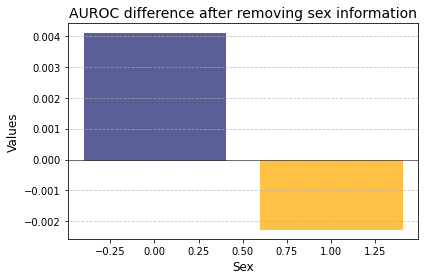

In [107]:
plt.figure(figsize=(6, 4))

# Create bar plot with custom colors
bars = plt.bar(cf_sex_sex_auc.keys(), cf_sex_sex_auc.values())


# Color bars based on positive/negative values
for i, value in enumerate(cf_sex_sex_auc.values()):
    if value >= 0:
        bars[i].set_color('#5B5F97')
    else:
        bars[i].set_color('#FFC145')

# Customize the plot
plt.title('AUROC difference after removing sex information', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/cf_sex_diff.pdf', dpi=300)
plt.show()

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns


def joint_plot(pca_0, pca_1, col, name, cat = None, savename = 'pca'):
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(4, 4, wspace=0, hspace=0)

    # Create the scatter plot and marginal axes
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
    ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)
    
    mask = []
    if cat is None:
        cat = np.unique(col)
    
    for category in cat:
        mask.append(col == category)
        
    mask = np.bitwise_or.reduce(mask, axis=0)
       
    pca_0 = pca_0[mask]
    pca_1 = pca_1[mask]
    col = col[mask]
    
    sns.scatterplot(x=pca_0, y=pca_1, hue=col, palette='deep', alpha=0.6,
                    ax=ax_scatter, legend=False)
    
    palette = sns.color_palette('deep', 15)
    for category, color in zip(cat, palette[:len(cat)]):
        mask = col == category
        sns.kdeplot(x=pca_0[mask], ax=ax_histx, color=color, fill=True, alpha=0.5, label=category)
        sns.kdeplot(y=pca_1[mask], ax=ax_histy, color=color, fill=True, alpha=0.5, label=category)

    ax_histx.set_ylabel('')
    ax_histx.set_title(name)
    ax_histy.set_xlabel('')

    ax_scatter.set_xlabel(f'PCA 0')
    ax_scatter.set_ylabel(f'PCA 1')

    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])

    ax_histx.grid(False)
    ax_histy.grid(False)

    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    plt.savefig(f'/data/Papers/MICCAI-biases/macaw-analysis/{savename}.pdf', dpi=300)
    plt.show()

    return fig


def heatmap(data, title):
    # Seaborn 1D Heatmap
    plt.figure(figsize=(20, 1))
    sns.heatmap(data, cmap='coolwarm', annot=True, fmt='.2f', cbar=False)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [109]:
obs_study = np.argmax(obs[:,0:9],axis=1)
obs_sex = obs[:,sex_idx]
obs_pd = obs[:,PD_idx]
obs_act = obs[:,ncauses:]
cf_study_act = cf_dict['Study_mean'][:,ncauses:]
cf_sex_act = cf_dict['Sex_mean'][:,ncauses:]

In [110]:
from sklearn.decomposition import PCA

pca = PCA(n_components=nlatents)
pca_obs =  pca.fit_transform(obs_act)
pca_cf_study =  pca.transform(cf_study_act)
pca_cf_sex =  pca.transform(cf_sex_act)

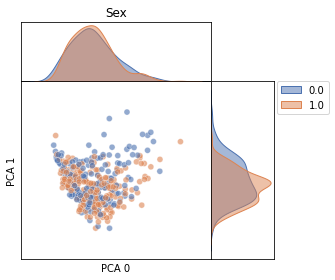

In [111]:
fig = joint_plot(pca_obs[:,0], pca_obs[:, 1], obs_sex, 'Sex', savename='obs_sex_pca0')

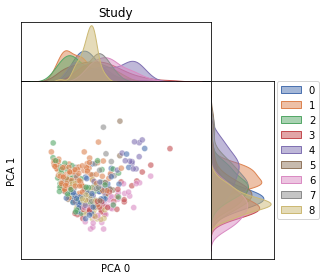

In [112]:
fig = joint_plot(pca_obs[:,0], pca_obs[:, 1], obs_study, 'Study',savename='obs_study_pca0')

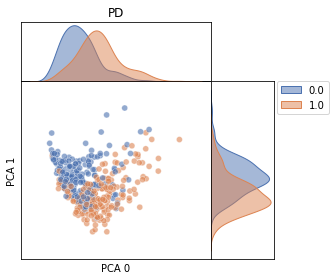

In [113]:
fig = joint_plot(pca_obs[:,0], pca_obs[:, 1], obs_pd, 'PD',savename='obs_pd_pca0')

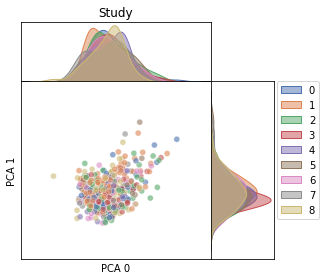

In [114]:
fig = joint_plot(pca_cf_study[:,0], pca_cf_study[:, 1], obs_study, 'Study',savename='cf_study_study_pca0')

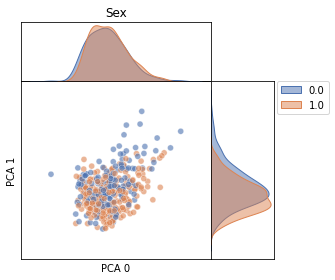

In [115]:
fig = joint_plot(pca_cf_study[:,0], pca_cf_study[:, 1], obs_sex, 'Sex',savename='cf_study_sex_pca0')

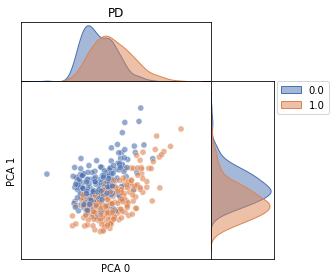

In [116]:
fig = joint_plot(pca_cf_study[:,0], pca_cf_study[:, 1], obs_pd, 'PD',savename='cf_study_pd_pca0')

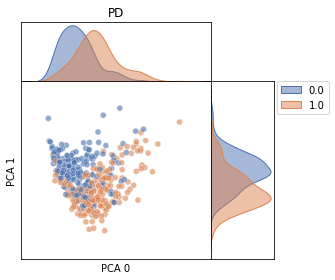

In [117]:
fig = joint_plot(pca_cf_sex[:,0], pca_cf_sex[:, 1], obs_pd, 'PD',savename='cf_sex_pd_pca0')

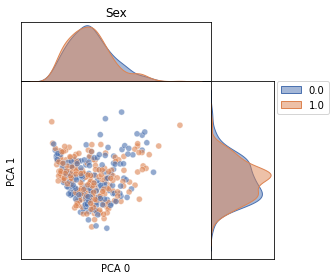

In [118]:
fig = joint_plot(pca_cf_sex[:,0], pca_cf_sex[:, 1], obs_sex, 'Sex',savename='cf_sex_sex_pca0')

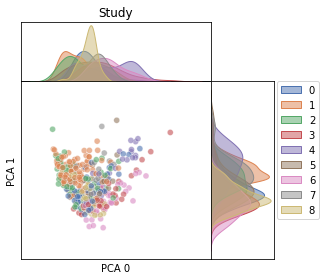

In [119]:
fig = joint_plot(pca_cf_sex[:,0], pca_cf_sex[:, 1], obs_study, 'Study',savename='cf_sex_study_pca0')

## Individual CF study - doesn't make sense yet

In [120]:
sus_dict = {'Study': obs_study, 'Sex': obs_sex, 'PD': obs_pd, 'obs_pred': obs_pred}

for k, v in cf_dict.items():
    sus_dict[k] = sigmoid(v[:, ncauses:] @ weights.T + bias).squeeze()

In [121]:
sus_df = pd.DataFrame.from_dict(sus_dict)
sus_df

,Study,Sex,PD,obs_pred,Study_0,Study_1,Study_2,Study_3,Study_4,Study_5,Study_6,Study_7,Study_8,Study_mean,Sex_0,Sex_1,Sex_mean
0,0,1.0,1.0,0.551684,0.551684,0.400982,0.389125,0.675718,0.740561,0.517613,0.747179,0.559836,0.575520,0.578164,0.528019,0.551684,0.539874
1,3,0.0,1.0,0.534174,0.455784,0.304061,0.284304,0.534174,0.635152,0.408803,0.664124,0.486737,0.521568,0.475264,0.534174,0.563866,0.549064
2,8,1.0,1.0,0.639685,0.627756,0.506985,0.506095,0.744945,0.800574,0.615553,0.795415,0.643628,0.639685,0.661512,0.626794,0.639685,0.633264
3,1,0.0,0.0,0.282611,0.410125,0.282611,0.272060,0.487446,0.586334,0.377686,0.617543,0.417150,0.471469,0.432373,0.282611,0.315809,0.298946
4,2,0.0,1.0,0.603885,0.701233,0.582207,0.603885,0.836973,0.875968,0.701243,0.858641,0.702758,0.690758,0.742239,0.603885,0.616092,0.610006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,1,1.0,0.0,0.320928,0.446263,0.320929,0.307158,0.557679,0.628334,0.417643,0.651422,0.449945,0.484685,0.472493,0.287524,0.320929,0.303968
412,4,0.0,0.0,0.777246,0.568195,0.441794,0.465639,0.719630,0.777246,0.564786,0.770846,0.565083,0.587036,0.614134,0.777246,0.777807,0.777526
413,5,1.0,1.0,0.660002,0.664660,0.565722,0.569859,0.787285,0.834036,0.660002,0.821959,0.680898,0.672408,0.704583,0.649504,0.660002,0.654772
414,1,1.0,0.0,0.323774,0.450150,0.323774,0.313404,0.543815,0.629234,0.423345,0.651371,0.464460,0.502383,0.476877,0.290317,0.323774,0.306792


In [122]:
auroc_dict = {}
bce_dict = {}

for k in cf_dict.keys():
    fpr, tpr, thresholds = roc_curve(sus_dict['PD'], sus_dict[k])
    roc_auc = auc(fpr, tpr)
    auroc_dict[k] = roc_auc - obs_roc_auc
    bce_dict[k] = BinaryCrossEntropy(sus_dict['PD'], sus_dict[k]) - obs_bce

<BarContainer object of 13 artists>

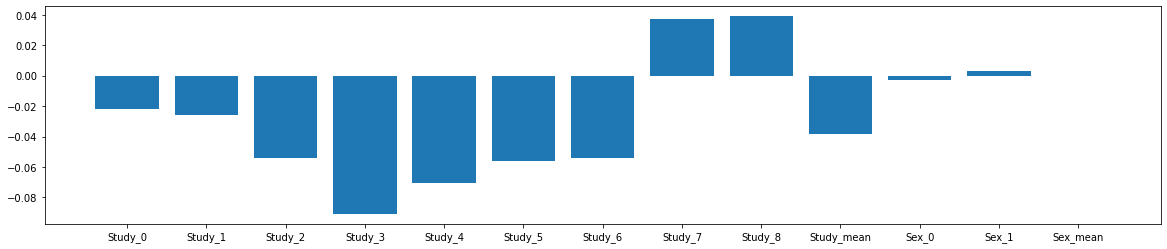

In [123]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20, 4))
plt.bar(auroc_dict.keys(), auroc_dict.values())

<BarContainer object of 13 artists>

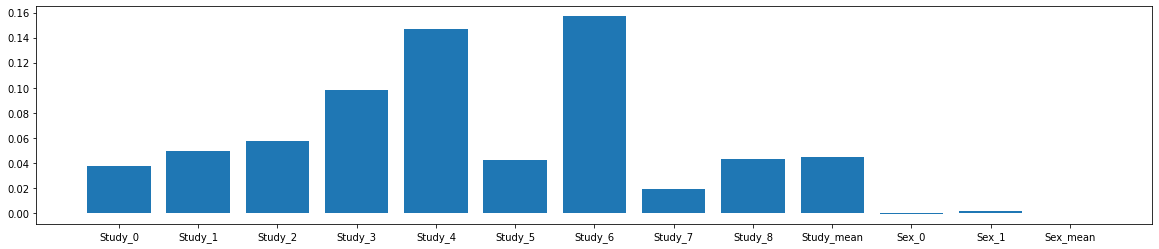

In [124]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(20, 4))
plt.bar(bce_dict.keys(), bce_dict.values())

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)
pca_dict = {'obs': pca.fit_transform(obs[:, 4:])}

for k, v in cf_dict.items():
    pca_dict[k] = pca.transform(v[:, 4:])

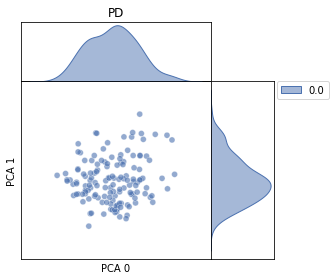

In [48]:
k = 'Study_6'
fig = joint_plot(pca_dict[k][:, 0], pca_dict[k][:, 1], obs[:, 0], 'PD', cat = [0.0])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 167 but corresponding boolean dimension is 416

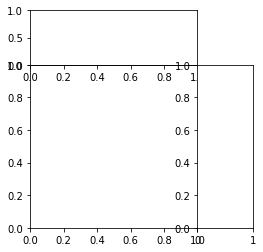

In [125]:
k = 'obs'
fig = joint_plot(pca_dict[k][:, 0], pca_dict[k][:, 1], obs[:, 0], 'PD')

In [26]:
fig = joint_plot(obs_latent_pca[:, 0], obs_latent_pca[:, 1], obs_sex, 'Study')

NameError: name 'obs_latent_pca' is not defined

In [ ]:
fig = joint_plot(cf_latent_pca[:, 0], cf_latent_pca[:, 1], obs_PD, 'PD')

In [ ]:
fig = joint_plot(cf_latent_pca[:, 0], cf_latent_pca[:, 1], obs_sex, 'PD')